<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/main/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [3]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub
!pip install --upgrade tensorflow
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=bb6d39e0e50613eb98f575721bcea91a486bc12bc8835dfe6bd45bf9496848a2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-e

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


## Libraries

In [1]:
# LIBRARIES

import os
import pandas as pd
import numpy as np
import json
import shutil
import random

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import History

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, T5Tokenizer, pipeline, TFT5ForConditionalGeneration
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge', seed=42) #It is not deterministic

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-1-c5cb458fe86c>:37: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge', seed=42) #It is not deterministic
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

## Logins, Paths and Auxiliar Functions

In [ ]:
# Connect w/ HuggingFace HUB
from huggingface_hub import notebook_login
notebook_login()

In [2]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# PATHS
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/"

documents = os.listdir(BASE_PATH)

Mounted at /content/drive/


In [3]:
# AUXILIAR FUNCTIONS

# Function to convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell



# Function to join all the sentences of input document
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data




# Define the metric to use (ROUGE Scores)
def metric_fn(eval_predictions):
  predictions, labels = eval_predictions

  for prediction in predictions:
      prediction[prediction < 0] = tokenizer.pad_token_id  # Replace masked prediction tokens

  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )

  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

## Preprocess Data

In [4]:
data = pd.read_csv(BASE_PATH+'Data/Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.sample(5)

,source,paper_id,target,title,number_words_target,extractive_summary
1155,Deep neural networks are vulnerable to adversa...,BJzVUj0qtQ,We propose an attention-invariant attack metho...,Evading Defenses to Transferable Adversarial E...,66,Attacking deep neural networks has drawn an in...
673,"Using variational Bayes neural networks, we de...",S1eEmn05tQ,A scalable method for learning an expressive p...,Uncertainty in Multitask Transfer Learning,70,More recent tools such as deep Gaussian proces...
878,Learning a better representation with neural n...,S17mtzbRb,A novel loss component that forces the network...,Forced Apart: Discovering Disentangled Represe...,74,"Output size: 128 In the past few years, a subs..."
1144,Deep convolutional neural network (DCNN) based...,Hy-lXyDWG,The paper is about a new energy-efficient meth...,Incremental Learning in Deep Convolutional Neu...,66,One of the major challenges for convolutional ...
1005,This paper studies the problem of domain divis...,H1GaLiAcY7,This paper studies the problem of domain divi...,Learning to Separate Domains in Generalized Ze...,88,This is different from the conventional Zero-S...


In [5]:
random.seed(42)

def shuffle_list(text):
    lst = text.split('. ')
    lst[:-1] = [sentence + '.' for sentence in lst[:-1]]
    random.shuffle(lst)
    return ' '.join(lst)

data['target'] = data['target'].apply(shuffle_list)

In [6]:
# Count number of words of source and target
def count_words(data, column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words(data, 'target')
data['number_words_source'] = count_words(data, 'source')
data['number_words_extractive'] = count_words(data, 'extractive_summary')

In [7]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    1312.000000
mean       58.935213
std        20.402388
min        30.000000
25%        41.000000
50%        58.000000
75%        73.000000
max       149.000000
Name: number_words_target, dtype: float64
count     1312.000000
mean      5177.437500
std       2107.094236
min        126.000000
25%       4069.750000
50%       5001.500000
75%       6187.750000
max      24589.000000
Name: number_words_source, dtype: float64
count    1312.000000
mean      621.176067
std       143.951058
min       126.000000
25%       534.000000
50%       611.000000
75%       693.000000
max      1199.000000
Name: number_words_extractive, dtype: float64


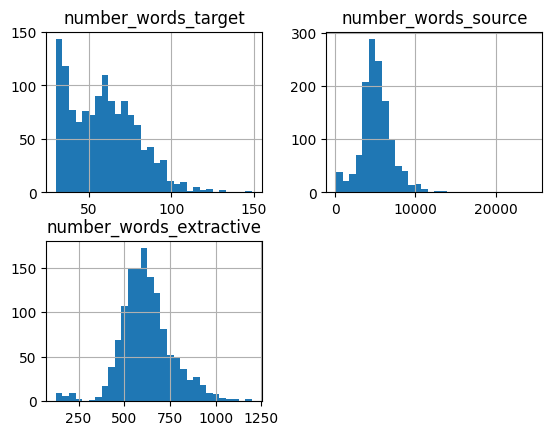

In [8]:
# Histogramas
data.hist(bins=30)
plt.show()

In [9]:
data = data[data['number_words_target']>=40].reset_index(drop=True)
data['number_words_target'].describe()

count    1012.000000
mean       66.381423
std        17.169049
min        40.000000
25%        54.000000
50%        64.000000
75%        77.000000
max       149.000000
Name: number_words_target, dtype: float64

In [10]:
synonyms_paper = ['paper', 'study', 'work', 'article']
articles = ['The', 'the', 'This', 'this', 'A', 'a', 'An', 'an']

def substitution(text, syn, articles):
  list_words = text.split()
  new_list_words = []
  for index, word in enumerate(list_words):
    if word in articles and list_words[index+1] in syn:
      new_list_words.append(word)
      new_list_words.append(random.choice(syn))
    elif word in syn and list_words[index-1] in articles:
      continue
    else:
      new_list_words.append(word)
  return ' '.join(new_list_words)

data['extractive_summary'] = data['extractive_summary'].apply(lambda x : substitution(x, synonyms_paper, articles))
data['target'] = data['target'].apply(lambda x : substitution(x, synonyms_paper, articles))

In [11]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      shuffle=True,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        shuffle=True,
                                        random_state=42)

In [12]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(647, 8) (162, 8) (809, 8) (203, 8)


In [13]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

## BART



#### Prepare Data for Tokenization

In [ ]:
# # Tokenize data
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', errors='ignore')

# # Function in order to tokenize source and target
# max_input_length = 1024

# def tokenize_function(data):
#   model_inputs = tokenizer(text=data['extractive_summary'], text_target=data['target'], max_length=max_input_length, truncation=True)
#   return model_inputs

# tokenized_data = raw_data.map(tokenize_function, batched=True)

In [15]:
# Tokenize data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', errors='ignore')

# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/647 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

### Prepare Data for Training

In [ ]:
# Load BART Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

model.generation_config.max_length = 150
model.generation_config.min_length = 60
model.generation_config.length_penalty = 2.0
model.generation_config.num_beams = 4

model.generation_config.do_sample = True
model.generation_config.temperature = 0.5
model.generation_config.begin_suppress_tokens  = [tokenizer.convert_tokens_to_ids('We')]
model.generation_config.suppress_tokens = [
    # tokenizer.convert_tokens_to_ids('Ġpaper'),
                                           tokenizer.convert_tokens_to_ids('ĠPro'),
                                          # tokenizer.convert_tokens_to_ids('Ġauthors'),
                                           tokenizer.convert_tokens_to_ids('ĠIntrodu')]
                                          #  tokenizer.convert_tokens_to_ids('Ġwork'),
                                          #  tokenizer.convert_tokens_to_ids('Ġmethod')]
if not model.generation_config.do_sample:
  model.generation_config.num_beam_groups = 4
  model.generation_config.diversity_penalty = 0.5

model.generation_config.no_repeat_ngram_size = 3

model.generation_config.repetition_penalty = 1.8

# model.generation_config.renormalize_logits = True

model.config.attention_dropout = 0.1

use_XLA = False
if use_XLA:
  model.generation_config.no_repeat_ngram_size = 0 # In order to use XLA Generation

name_model = 'sampling-norep-v3/'

print(model.generation_config)


batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 60,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ],
  "temperature": 0.5
}



In [ ]:
model.config

BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_ty

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

if use_XLA:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)
else:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

In [ ]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [ ]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(100):  # Take the first batch for inspection
    print(batch[0])

{'input_ids': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[    0,   170,   311, ...,     1,     1,     1],
       [    0, 20930,    15, ...,     1,     1,     1],
       [    0, 35703,     6, ...,     1,     1,     1],
       ...,
       [    0,  3376,  5969, ...,     1,     1,     1],
       [    0, 44891,     7, ...,     1,     1,     1],
       [    0,     6,   992, ...,    81, 14307,     2]])>, 'attention_mask': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])>, 'decoder_input_ids': <tf.Tensor: shape=(8, 182), dtype=int64, numpy=
array([[    2,     0,   250, ...,     1,     1,     1],
       [    2,     0,  1121, ...,     1,     1,     1],
       [    2,     0,   250, ...,     1,     1,     1],
       ...,
       [    2,     0,   170, ...,     1,     1,     1],
       

In [ ]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [ ]:
save_path = BASE_PATH + '/Results/TLDR/BART/model_save/' + name_model

In [ ]:
#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True,
    use_xla_generation=use_XLA
)

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./model_save",
#     tokenizer=tokenizer,
#     hub_model_id="iguerrasevillano/BART-summ-v1",
#     save_strategy='epoch',
#     checkpoint=True
# )


checkpoint_callback = ModelCheckpoint(
    filepath=save_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
resume = False
epochs = 10

callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early,
             checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

# Save the model and tokenizer to a directory
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

[INFO: fine-tuning model...]
Epoch 1/10
81/81 [==============================] - 3557s 44s/step - loss: 3.8539 - val_loss: 3.3430 - rouge1: 38.3698 - rouge2: 10.1688 - rougeL: 22.2593 - rougeLsum: 31.8182 - gen_len: 88.4506
Epoch 2/10
81/81 [==============================] - 3040s 38s/step - loss: 3.4917 - val_loss: 3.2807 - rouge1: 40.0500 - rouge2: 10.8711 - rougeL: 22.9560 - rougeLsum: 33.0063 - gen_len: 82.0000
Epoch 3/10
81/81 [==============================] - 3153s 39s/step - loss: 3.3288 - val_loss: 3.2417 - rouge1: 39.2427 - rouge2: 10.4373 - rougeL: 22.8725 - rougeLsum: 32.7607 - gen_len: 82.4815
Epoch 4/10
81/81 [==============================] - 3104s 39s/step - loss: 3.1818 - val_loss: 3.2276 - rouge1: 40.0325 - rouge2: 11.1820 - rougeL: 23.2123 - rougeLsum: 33.2422 - gen_len: 84.0309
Epoch 5/10
81/81 [==============================] - 3291s 41s/step - loss: 3.0478 - val_loss: 3.2148 - rouge1: 40.4019 - rouge2: 10.9217 - rougeL: 23.2547 - rougeLsum: 33.4422 - gen_len: 85.5

('/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/tokenizer_config.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/special_tokens_map.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/vocab.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/merges.txt',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/added_tokens.json')

In [ ]:
with open(save_path + 'training_history.json', 'w') as file:
    json.dump(H.history, file)

In [ ]:
# List all files in the source folder
weights_last_epoch = 'tf_model.h5'

source_file_path = os.path.join(save_path, weights_last_epoch)
os.makedirs(save_path + 'last_epoch/')
destination_file_path = os.path.join(save_path, 'last_epoch/', weights_last_epoch)
shutil.move(source_file_path, destination_file_path)

print(f"File {weights_last_epoch} moved from {source_file_path} to {destination_file_path}")

File tf_model.h5 moved from /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/tf_model.h5 to /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3/last_epoch/tf_model.h5


In [ ]:
# Change name
original_path = save_path + '/weights.h5'
new_name = 'tf_model.h5'

# Create the new file path
new_path = os.path.join(os.path.dirname(original_path), new_name)

# Rename the file
os.rename(original_path, new_path)

print(f"File weights.h5 renamed as {new_name}")

File weights.h5 renamed as tf_model.h5


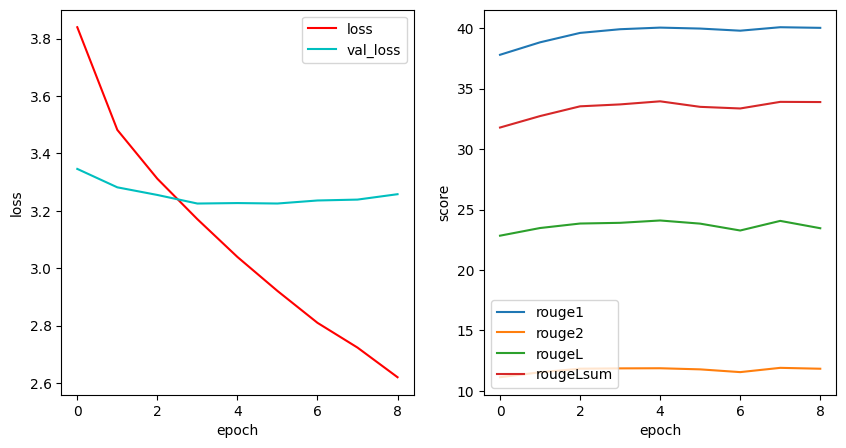

In [ ]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], 'r', label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], 'c', label="val_loss")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc="upper right")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeL"], label="rougeL")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeLsum"], label="rougeLsum")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('score')
    ax[1].legend()

plot_graphics(H)
plt.savefig(save_path + '/history.png')

### Evaluation

In [ ]:
name_models = {'sampling-norep-v0' : 'sampling-norep-v0/',
              #  'sampling-norep-v1' : 'sampling-norep-v1/',
              #  'greedy-norep-v0' : 'greedy-norep-v0/',
              #  'greedy-norep-v1' : 'greedy-norep-v1/',
              #  'greedy-norep-v2' : 'greedy-norep-v2/',
              #  'greedy-norep-v3' : 'greedy-norep-v3/',
               'sampling-norep-v3' : 'sampling-norep-v3'}

save_paths = {}
models = {}
# tokenizers = {}

for name in name_models:
  save_paths[name] = BASE_PATH + '/Results/TLDR/BART/model_save/' + name_models[name]

  models[name] = TFAutoModelForSeq2SeqLM.from_pretrained(save_paths[name])
  # tokenizers[name] = BartTokenizer.from_pretrained(save_path[name])
  print(models[name].generation_config)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 150,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.2,
  "temperature": 0.5
}



All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 60,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ],
  "temperature": 0.5
}



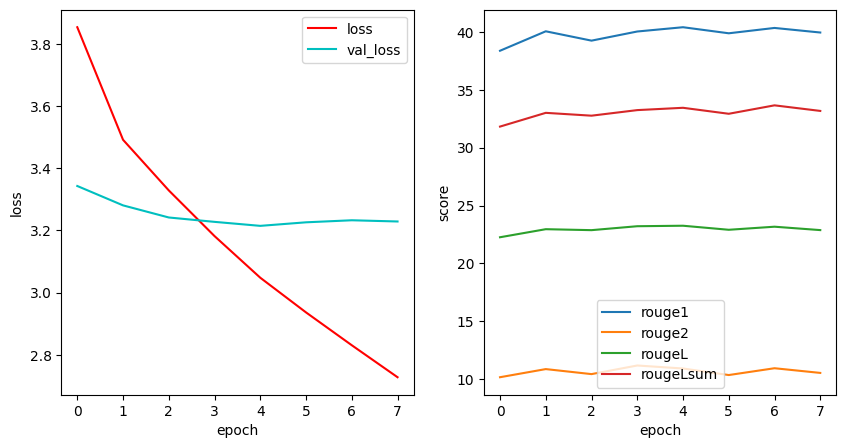

In [ ]:
name = 'sampling-norep-v3'
save_path = save_paths[name]

with open(save_path + '/training_history.json', 'r') as file:
    loaded_history = json.load(file)

H = History()
H.history = loaded_history


def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], 'r', label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], 'c', label="val_loss")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc="upper right")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeL"], label="rougeL")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeLsum"], label="rougeLsum")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('score')
    ax[1].legend()

plot_graphics(H)
plt.savefig(save_path + '/figure.png')

In [ ]:
name = 'sampling-norep-v3'

In [ ]:
ids = models[name].generate(tokenized_data['test']['input_ids'][:5],
                                        generation_config=models[name].generation_config,
                                        seed=42)

In [ ]:
ids = model.generate(tokenized_data['test']['input_ids'][6:8],
                                        generation_config=model.generation_config,
                                        seed=42)

In [ ]:
tokenizer.batch_decode(ids, skip_special_tokens=True)

['A variational Dirichlet framework for in-and out-of-distribution classification. This paper proposes a variational approach to solve the uncertainty estimation problem in deep neural networks by considering the label-level distribution of image input and output labels. The authors propose a new uncertainty metric for deep neural network classification that is more robust than existing uncertainty measures. This article proposes a novel variational method for solving uncertainty estimation on deep neural nets.',
 'An unsupervised method for analyzing the contribution of individual neurons to NMT models. This paper proposes a novel approach to interpret language pairs using neural networks, and proposes a new method for measuring the contributions of each neuron to the model. The authors propose a novel method for learning languages from neural networks that can be used to control the translation performance of language pairs.',
 'A deep diagonal-circulant ReLU network that can be deco

In [ ]:
tokenized_data['test']['target'][:5]

['A new framework based variational inference for out-of-distribution detection Describes a probabilistic approach to quantifying uncertainty in DNN classification tasks that outperforms other SOTA methods in the task of out-of-distribution detection. A new framework for out-of-distribution detection, based on variaitonal inference and a prior Dirichlet distribution, that reports state of the art results on several datasets. An out-of distribution detection via a new method to approximate the confidence distribution of classification probability using variational inference of Dirichlet distribution.',
 'Unsupervised methods for finding, analyzing, and controlling important neurons in NMT This study presents unsupervised approaches to discovering important neurons in neural machine translation systems and analyzes linguistic properties controlled by those neurons. Unsupervised methods for ranking neurons in machine translation where important neurons are thus identified and used to cont

['A new framework based variational inference for out-of-distribution detection Describes a probabilistic approach to quantifying uncertainty in DNN classification tasks that outperforms other SOTA methods in the task of out-of-distribution detection. A new framework for out-of-distribution detection, based on variaitonal inference and a prior Dirichlet distribution, that reports state of the art results on several datasets. An out-of distribution detection via a new method to approximate the confidence distribution of classification probability using variational inference of Dirichlet distribution.',
 'Unsupervised methods for finding, analyzing, and controlling important neurons in NMT This study presents unsupervised approaches to discovering important neurons in neural machine translation systems and analyzes linguistic properties controlled by those neurons. Unsupervised methods for ranking neurons in machine translation where important neurons are thus identified and used to cont

In [ ]:
model = models[name]
model.generation_config.max_length = 150
model.generation_config.min_length = 60
model.generation_config.length_penalty = 2.0
model.generation_config.num_beams = 4

model.generation_config.do_sample = False
model.generation_config.temperature = 1
model.generation_config.begin_suppress_tokens  = [tokenizer.convert_tokens_to_ids('We')]
model.generation_config.suppress_tokens = [
    # tokenizer.convert_tokens_to_ids('Ġpaper'),
                                           tokenizer.convert_tokens_to_ids('ĠPro'),
                                          tokenizer.convert_tokens_to_ids('Ġpropose'),
                                           tokenizer.convert_tokens_to_ids('Ġproposes'),
                                          # tokenizer.convert_tokens_to_ids('Ġauthors'),
                                           tokenizer.convert_tokens_to_ids('ĠIntrodu')]
                                          #  tokenizer.convert_tokens_to_ids('Ġwork'),
                                          #  tokenizer.convert_tokens_to_ids('Ġmethod')]

model.generation_config.num_beam_groups = 4
model.generation_config.diversity_penalty = 0.7

model.generation_config.no_repeat_ngram_size = 3

model.generation_config.repetition_penalty = 1.3

print(model.generation_config)

GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.7,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 60,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.3,
  "suppress_tokens": [
    1698,
    15393,
    21037,
    32687
  ]
}



In [ ]:
tokenizer.tokenize('they proposes')

['they', 'Ġproposes']

In [ ]:
generated_summaries = []
rouge_scores = []
accumulated_metrics = {}

n = len(tokenized_data['test']['input_ids'])
batch_size = 2 # Must be greater than 1

# Last batch is dropped (just one sample if batch_size=2) to average ROUGE scores properly
for i in range(0, n-1, batch_size):
  if i % 10 == 0:
    print(f'[INFO]: {i}/{n-1}')


  generated_ids = models[name].generate(tokenized_data['test']['input_ids'][i:i+batch_size],
                                        generation_config=models[name].generation_config,
                                        seed=42)
  reference_labels = np.array(tokenized_data['test']['labels'][i:i+batch_size])

  predicted_labels = np.array(generated_ids)

  current_metrics = metric_fn((predicted_labels, reference_labels))
  accumulated_metrics = {k : current_metrics.get(k, 0) + accumulated_metrics.get(k, 0) for k in current_metrics.keys()}

  # Predicted summaries, keep the rouge scores
  generated_summaries.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
  rouge_scores.append(current_metrics)

# Undo nested list
generated_summaries = [summary for summaries in generated_summaries for summary in summaries]
average_rouge_scores = {k : accumulated_metrics.get(k, 0)/len(range(0, n-1, batch_size)) for k in accumulated_metrics.keys()}

[INFO]: 0/202
[INFO]: 10/202
[INFO]: 20/202
[INFO]: 30/202
[INFO]: 40/202
[INFO]: 50/202
[INFO]: 60/202
[INFO]: 70/202
[INFO]: 80/202
[INFO]: 90/202
[INFO]: 100/202
[INFO]: 110/202
[INFO]: 120/202
[INFO]: 130/202
[INFO]: 140/202
[INFO]: 150/202
[INFO]: 160/202
[INFO]: 170/202
[INFO]: 180/202
[INFO]: 190/202
[INFO]: 200/202


In [ ]:
model = models[name]
model.generation_config

GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.5,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 80,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ]
}

In [ ]:
save_path

'/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/greedy-norep-v5'

In [ ]:
updated_data_test = data_test[:-1].reset_index(drop=True)
updated_data_test['abstractive_summary'] = pd.Series(generated_summaries)

updated_data_test['number_words_abstractive'] = count_words(updated_data_test, 'abstractive_summary')

updated_data_test['length_difference'] = updated_data_test['number_words_target'] - updated_data_test['number_words_abstractive']

updated_data_test.to_csv(save_path + '/updated_data_test.csv', index=False)

summaries = updated_data_test[['target', 'abstractive_summary']]
summaries.to_csv(save_path + '/summaries.csv', index=False)

with open(save_path + '/average_rouge_scores.json', 'w') as json_scores:
    json.dump(average_rouge_scores, json_scores, indent=4)

In [ ]:
updated_data_test['length_difference'].describe()

count    202.000000
mean       1.420792
std       18.729447
min      -39.000000
25%      -12.000000
50%        0.500000
75%       14.000000
max       53.000000
Name: length_difference, dtype: float64

In [ ]:
i = 6
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:OE teaches anomaly detectors to learn heuristics for detecting unseen anomalies; experiments are in classification, density estimation, and calibration in NLP and vision settings; we do not tune on test distribution samples, unlike previous work
FINE TUNED MODEL:Outlier Exposure improves the calibration of neural network classifiers in the realistic setting where a fraction of the data is OOD. We show that Outlier Exposure can improve calibration performance in this realistic setting.
PRETRAINED MODEL:However, when there is a distribution mismatch, deep neural network classifiers tend to give


In [ ]:
m = 28
print(summaries.iloc[m, 0])
print(summaries.iloc[m, 1])

We train with state aligned vector rewards an agent predicting state changes from action distributions, using a new reinforcement learning technique inspired by quantile regression. Presents algorithm that aims to speed up reinforcement learning in situations where the reward is aligned with the state space.  This paper addresses RL in the continuous action space, using a re-parametrised policy and a novel vector-based training objective. This work proposes to mix distributional RL with a net in charge of modeling the evolution of the world in terms of quantiles, claiming improvements in sample efficiency.
We extend the reinforcement learning paradigm to a d-dimensional hypercube and show that quantile regression is capable of training orders of magnitudes faster in high dimensional metric spaces. This paper proposes a method to train a deep neural network to approximate the quantile function of the optimal action distribution. The authors propose a new reinforcement learning algorithm

# T5

In [14]:
# Tokenize data
tokenizer = T5Tokenizer.from_pretrained('google-t5/t5-small', errors='ignore')
prefix = 'summarize: '

# Function in order to tokenize source and target
max_input_length = 512

def tokenize_function(data):
  inputs = [prefix + input for input in data['extractive_summary']]
  model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/647 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [15]:
# Load T5 Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained('google-t5/t5-small')


model.generation_config.max_length = 100
model.generation_config.min_length = 80
model.generation_config.num_beams = 4
model.generation_config.length_penalty = 2.0


# model.generation_config.do_sample = True
# model.generation_config.temperature = 0.5
bad_words = ['We', 'we', "propose", 'authors']
model.generation_config.bad_words_ids=tokenizer(bad_words, add_special_tokens=False).input_ids
# model.generation_config.suppress_tokens = [
#     # tokenizer.convert_tokens_to_ids('Ġpaper'),
#                                            tokenizer.convert_tokens_to_ids('ĠPro'),
#                                           # tokenizer.convert_tokens_to_ids('Ġauthors'),
#                                            tokenizer.convert_tokens_to_ids('ĠIntrodu')]
#                                           #  tokenizer.convert_tokens_to_ids('Ġwork'),
#                                           #  tokenizer.convert_tokens_to_ids('Ġmethod')]
if not model.generation_config.do_sample:
  model.generation_config.num_beam_groups = 4
  model.generation_config.diversity_penalty = 0.5

model.generation_config.no_repeat_ngram_size = 3

model.generation_config.repetition_penalty = 1.8

name_model = 'greedy-norep-v1/'

print(model.config)
print(model.generation_config)

use_XLA = False

batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


T5Config {
  "_name_or_path": "google-t5/t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

if use_XLA:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)
else:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

In [17]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [18]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
save_path = BASE_PATH + '/Results/TLDR/T5/model_save/' + name_model

In [20]:

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True,
    use_xla_generation=use_XLA
)


checkpoint_callback = ModelCheckpoint(
    filepath=save_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [21]:
resume = False
epochs = 30

callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early,
             checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

# Save the model and tokenizer to a directory
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

[INFO: fine-tuning model...]
Epoch 1/30


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
81/81 [==============================] - 2525s 31s/step - loss: 4.3423 - val_loss: 2.4052 - rouge1: 29.2941 - rouge2: 5.1047 - rougeL: 16.6952 - rougeLsum: 23.6122 - gen_len: 91.7222
Epoch 2/30
81/81 [==============================] - 2387s 30s/step - loss: 2.5262 - val_loss: 2.2012 - rouge1: 29.5408 - rouge2: 5.4763 - rougeL: 16.8709 - rougeLsum: 23.6416 - gen_len: 90.3704
Epoch 3/30
81/81 [==============================] - 2454s 31s/step - loss: 2.2226 - val_loss: 2.1392 - rouge1: 30.7530 - rouge2: 5.8785 - rougeL: 17.4531 - rougeLsum: 24.5442 - gen_len: 91.7469
Epoch 4/30
81/81 [==============================] - 2449s 31s/step - loss: 2.0407 - val_loss: 2.0969 - rouge1: 31.5789 - rouge2: 6.1595 - rougeL: 17.9123 - rougeLsum: 25.1060 - gen_len: 91.8086
Epoch 5/30
81/81 [==============================] - 2457s 31s/step - loss: 1.9592 - val_loss: 2.0

('/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/T5/model_save/greedy-norep-v1/tokenizer_config.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/T5/model_save/greedy-norep-v1/special_tokens_map.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/T5/model_save/greedy-norep-v1/spiece.model',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/T5/model_save/greedy-norep-v1/added_tokens.json')

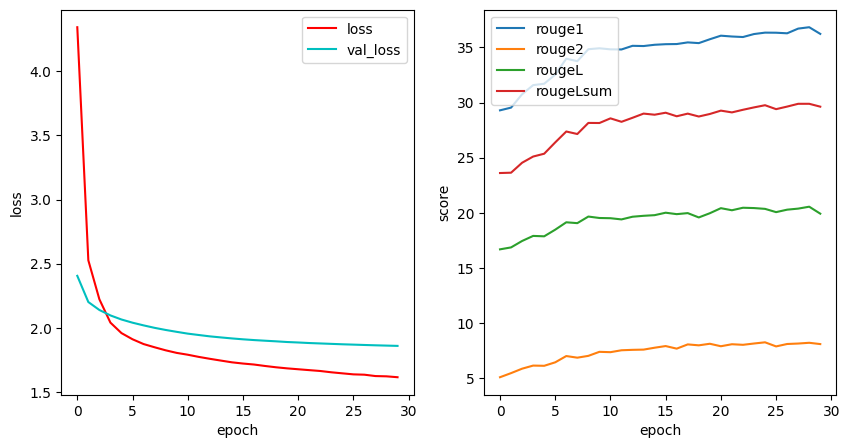

In [22]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], 'r', label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], 'c', label="val_loss")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc="upper right")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeL"], label="rougeL")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeLsum"], label="rougeLsum")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('score')
    ax[1].legend()

plot_graphics(H)
plt.savefig(save_path + '/history.png')

In [22]:
model.generation_config

GenerationConfig {
  "begin_suppress_tokens": [
    1326
  ],
  "decoder_start_token_id": 0,
  "diversity_penalty": 0.5,
  "eos_token_id": 1,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 80,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 0,
  "repetition_penalty": 1.8
}

In [ ]:
bad_words = ['We',"we", "propose", 'authors']
bad_words_ids=tokenizer(bad_words, add_special_tokens=False).input_ids

In [23]:

ids = model.generate(tokenized_data['test']['input_ids'][:8],
                                        seed=42)

tokenizer.batch_decode(ids, skip_special_tokens=True)

['This article introduces a variational Dirichlet algorithm for deep neural network classification problem. The paper presents a new method for detecting out-of-distribution images by using the label-wise distribution P(y) over the simplex S k. This article examines the image classification problem with image input as x and output label as y. A variational dirichlet framework that can greatly widen the distance between in-and out of-',
 'This study introduces a new method for analyzing the contribution of individual neurons to NMT models by modifying the activation of the tense neurons from the previous section TAB2. The paper presents a novel translation control technique that can be used to predict tokens inside/outside of parentheses, quotes, or brackets. This work explores the role of linguistically interpretable neurons in translating neural networks into vector representations.',
 'This study introduces a new neural network architecture that can approximate a deep ReLU network in

In [137]:
bad_words = ['We',"we", "propose"]
tokenizer(bad_words, add_special_tokens=False)

{'input_ids': [[101, 1], [62, 1], [4230, 1]], 'attention_mask': [[1, 1], [1, 1], [1, 1]]}

In [138]:
tokenizer.tokenize('authors')

['▁authors']

In [110]:
tokenizer.convert_tokens_to_ids(['_We'])

[2]

In [104]:
input_text = "We is an example sentence."

# Tokenize the input text
tokenized_input = tokenizer(input_text, return_tensors="tf")

# Print the tokenized input
print("Tokenized input:", tokenized_input)

# Generate output based on the tokenized input
output = model.generate(**tokenized_input)


Tokenized input: {'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[ 101,   19,   46,  677, 7142,    5,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [103]:
decoded_output

'This is a example example sentence for example. The example sentence is an example sentence, and it is based on a simple example sentence in this example sentence. It is one example sentence of example sentence to a sentence that is used as a examples sentence for Example Example Example For Example Example In An Example Example To Example Example A Example Example Examples Example Example Uses Example Example sentences.'

In [97]:
tokenizer.convert_tokens_to_ids(['▁We',
 '▁use',
 '▁it',
 'er',
 'ative',
 '▁pruning',
 '▁as',
 '▁',
 'a',
 '▁proxy',
 '▁for',
 '▁the',
 '▁speed',
 '▁at',
 '▁which',
 '▁',
 'a',
 '▁network',
 '▁learn',
 's',
 '.'])

[101,
 169,
 34,
 49,
 1528,
 31858,
 38,
 3,
 9,
 19784,
 21,
 8,
 1634,
 44,
 84,
 3,
 9,
 1229,
 669,
 7,
 5]

In [ ]:
ids = model.generate(tokenized_data['test']['input_ids'][:8],
                                        seed=42)

tokenizer.batch_decode(ids, skip_special_tokens=True)

["black-box watermarking papers embed the WM as a statistical bias in the decision boundaries of the DNN. the watermark must be secure against adversarial attacks and leave no tangible footprints in the target DNN. a retraining procedure resembles 'adversarial training' BID16. a retraining procedure resembles 'adversarial training' BID16.",
 '',
 '',
 'we hypothesize that the use of different normalization statistics during training and inference is the main cause of this adversarial vulnerability in the BatchNorm layer. we consider a standard classification task for data, having underlying distribution denoted as D, over the pair of examples x  R n and corresponding true labels y  1, 2,..., k where k represents different labels.',
 'a method for learning good representations in a self-supervised way is by training a neural network to solve an auxiliary task for which obtaining data is free or at least very inexpensive. a method for learning good representations in a self-supervised wa

In [31]:
tokenized_data['test']['target'][:8]

['A new framework based variational inference for out-of-distribution detection Describes a probabilistic approach to quantifying uncertainty in DNN classification tasks that outperforms other SOTA methods in the task of out-of-distribution detection. A new framework for out-of-distribution detection, based on variaitonal inference and a prior Dirichlet distribution, that reports state of the art results on several datasets. An out-of distribution detection via a new method to approximate the confidence distribution of classification probability using variational inference of Dirichlet distribution.',
 'Unsupervised methods for finding, analyzing, and controlling important neurons in NMT This paper presents unsupervised approaches to discovering important neurons in neural machine translation systems and analyzes linguistic properties controlled by those neurons. Unsupervised methods for ranking neurons in machine translation where important neurons are thus identified and used to cont

In [ ]:
model.config.do_lower_case

AttributeError: 'T5Config' object has no attribute 'do_lower_case'

In [ ]:
tokenizer.encode('hello')


[21820, 1]

In [ ]:
tokenizer.encode('Hello')

[8774, 1]